In [1]:
# Copyright 2018 Anar Amirli
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Model Testing

In this document, we try both classification and regression approaches for testing the model.

In [2]:
%matplotlib  inline

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
import itertools



from utils import *

In [3]:
def describe_dataset(y_val): 
    heading = 'Pitch index counts'
    print(heading + '\n' + '-'*len(heading))
    for key, val in sorted(Counter(y_val).items()):
        print('{}\t: {}'.format(int(key), val))

In [3]:
train_data = pd.read_csv('../data/general/train/all_train_3.csv')

## Labale and Columns Names

In [5]:
classes = ['Index: Null']
for i in range(1,len((all_data['pitch_index'].unique()))):
    classes.append('Index: ' + str(i))
feature_names = list(all_data.columns[:-3])

## Cross Validation Function for Classification

In [22]:
def random_forest_cv(clf, X, y, feature_names, classes=None, k=10):
    label_ids = sorted(np.unique(y), key=abs)
    
    # shuffle the data
    X, y = shuffle(X, y)
    
    # get K folds
    skf = KFold(n_splits=k, shuffle=True)
    skf.get_n_splits(X, y)
    
    # cumulative confusion matrix and feature importance arrays
    conf_mat = np.zeros((len(label_ids), len(label_ids)))
    feature_importances = np.zeros(X.shape[1])
    
    # for each fold in KFold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # fit with current train set
        clf = clf.fit(X_train, y_train)
        # predict the current test set
        y_pred = clf.predict(X_test)
        
        # keep cumulative sum of conf_mat and feature_importances
        conf_mat += confusion_matrix(y_test, y_pred, labels=label_ids)
        feature_importances += clf.feature_importances_
     
    # normalize importances
    feature_importances /= k
    
    if classes is None:
        classes = label_ids
    
    # plot
    plot_confusion_matrix(conf_mat, classes, 'Prediction', 'Truth', normalize=True)
    plot_hbar_nameval(feature_names, feature_importances, 'Feature importances', max_bars=20)
    
    all_pred=0.0
    true_pred=0.0
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            all_pred+=cm[i][j]
            if i==j:
                true_pred+=cm[i][j]
                
    true_pred /= all_pred
    
    return true_pred, conf_mat, feature_importances

## Random Undersampling

Undersampling is one of the techniques used for handling class imbalance. In this technique, we under sample majority class to match the minority class. So in our example, we reduce the  sample of null segment class to match other segments samples. This makes sure that the training data has equal amount of samples.

In [7]:
describe_dataset(train_data.values[:, -3])

Pitch index counts
------------------
0	: 174376
1	: 16287
2	: 39363
3	: 15413
4	: 48708
5	: 142437
6	: 49261
7	: 17806
8	: 44841
9	: 20871


In [8]:
if Counter(train_data['pitch_index']).most_common(2)[0][0]==0:
        max_occurecnce = Counter(train_data['pitch_index']).most_common(2)[0][1]
        count=0
        thserhlod_value=0
        for key, val in sorted(Counter(train_data['pitch_index']).items()):
                if key!=0 and key!=1 and key!=3 and key!=7 and key!=9 and key!=5:
                    thserhlod_value+=val
                    count+=1
        thserhlod_value= thserhlod_value//(count-1)

        # Get indices of zero_indices samples
        zero_indices = train_data[train_data['pitch_index'] == 0].index
        
        # Random sample zero_indices
        random_indices = np.random.choice(zero_indices,thserhlod_value, replace=False)
        
        # Find the indices of non_zero samples
        non_zero_indices = train_data[train_data['pitch_index'] != 0].index
        
        # Concat non_zero_indices indices with sample zero_indices
        under_sample_indices = np.concatenate([non_zero_indices,random_indices])
        
        # Get Balance Dataframe
        train_data = train_data.loc[under_sample_indices]

        train_data = train_data.sample(frac=1).reset_index(drop=True)
        
        # Get indices of five_indices samples
        five_indices = train_data[train_data['pitch_index'] == 5].index
        
        thserhlod_value=50000
        
        # Random sample zero_indices
        random_indices = np.random.choice(five_indices,thserhlod_value, replace=False)
        
        # Find the indices of non_zero samples
        non_five_indices = train_data[train_data['pitch_index'] != 5].index
        
        # Concat non_zero_indices indices with sample zero_indices
        under_sample_indices = np.concatenate([non_five_indices,random_indices])
        
        # Get Balance Dataframe
        train_data = train_data.loc[under_sample_indices]

        train_data = train_data.sample(frac=1).reset_index(drop=True)
        
        
        
        
describe_dataset(train_data.values[:, -3])

Pitch index counts
------------------
0	: 60724
1	: 16287
2	: 39363
3	: 15413
4	: 48708
5	: 50000
6	: 49261
7	: 17806
8	: 44841
9	: 20871


## SMOTE
SMOTE (Synthetic Minority Over-Sampling Technique) is an over-sampling technique that introduces small perturbations to synthetic examples along the direction of existing samples to reduce overfitting. See original paper for detailed explanation of SMOTE.
## SMOTE Implementation
There is a SMOTE implementation in imblearn package for scikit-learn. However, there is not an option to apply SMOTE with arbitrary percentages (SMOTE-100, SMOTE-300, etc.); it simply balances all the classes. And also since SMOTE is not a hard to implement algorithm, we provide our own implementation. Our dataset sizes are not big (order of 10k). Hence, a simple Python implementation would be more than sufficien for our needs. See the original paper for reference algorithm.

In [9]:
from sklearn.neighbors import NearestNeighbors
from random import randint


def smote(samples, amount, k=5):
    """
    Apply SMOTE algorithm to samples and return a new samples
    array with synthetically created samples.
    
    Parameters
    ----------
    samples: (n_samples, n_features) samples array to be sent to
             SMOTE algorithm.
    amount: Percentage of newly created synthetic samples. (E.g.
            amount=100 would create as many synthetic examples
            as existing ones).
    k: Number of nearest neighbors in SMOTE algorithm.
    
    Returns
    -------
    out: ((1 + amount/100)*n_samples, n_features) samples array containing
         the original and the newly created synthetic examples.
         
    References
    ----------
    http://www.jair.org/media/953/live-953-2037-jair.pdf
    """
    samples = np.copy(samples)
    n_samples, n_features = samples.shape
    # handle amount < 100 case
    if amount < 100:
        num_samples = int(len(samples)*(amount/100))
        np.shuffle(samples)
        samples = samples[:num_samples, :]
        amount = 100
    amount = int(amount/100)
    synthetic = np.empty((n_samples*amount, n_features))
    # find k nearest neighbors of each point and store it in nnarray
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(samples)
    _, nnarray = nbrs.kneighbors(samples)
    nnarray = nnarray[:, 1:]  # get rid of self-nearest-neighbor.
    # create synthetic examples and store them in synthetic.
    for i, neighbors in enumerate(nnarray):
        for j in range(amount):
            chosen = neighbors[randint(0, k - 1)]
            diff = samples[chosen] - samples[i]
            gap = np.random.rand(n_features)
            synthetic[i*amount + j] = samples[i] + gap*diff
    out = np.vstack((samples, synthetic))
    
    return out

In [10]:
describe_dataset(train_data.values[:, -3])

Pitch index counts
------------------
0	: 60724
1	: 16287
2	: 39363
3	: 15413
4	: 48708
5	: 50000
6	: 49261
7	: 17806
8	: 44841
9	: 20871


## SMOTE for  Segmnets

Assigment number of corner segments in our dataset is much fewer than other segments. We use SMOTE algorithm with various synthetic example amounts to generate more examples for this segments.

We can't use nominal features in our current SMOTE implementation

TODO: Implement SMOTE-NC

In [ ]:
from sklearn.utils import shuffle

def smote_sampling(X, y, pitch_segment):
    smote_amount = 100
    pitch_segment_mask = y == pitch_segment
    
    penalty_features = X[pitch_segment_mask]
    synthetic_penalty = smote(penalty_features, smote_amount)
    n_synthetic = len(synthetic_penalty)

    # merge synthetic examples with original examples
    X_out = np.vstack((X[~pitch_segment_mask], synthetic_penalty))
    y_out = np.concatenate((y[~pitch_segment_mask], [pitch_segment]*n_synthetic))

    return X_out, y_out

x_train = train_data.values[:, 0:-3]
y_train = train_data.values[:, -3]

X_out, y_out = smote_sampling(x_train, y_train, 1)
X_out, y_out = smote_sampling(X_out, y_out, 3)
X_out, y_out = smote_sampling(X_out, y_out, 13)
X_out, y_out = smote_sampling(X_out, y_out, 15)

#describe_dataset(y_out)

# Classifier Testing

### 10-Fold Cross Validation on Training Data
In this section, we test our model parameters using cross validation on training data. Classifier used in this section is not previously trained. Hence, it is not our final model.

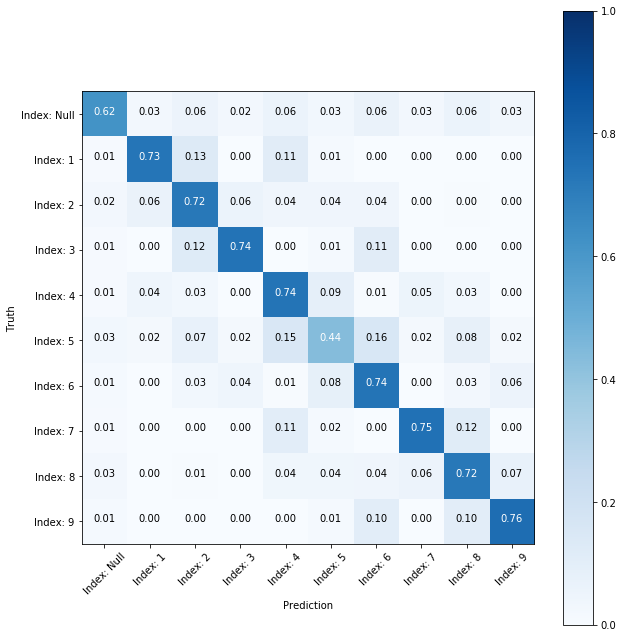

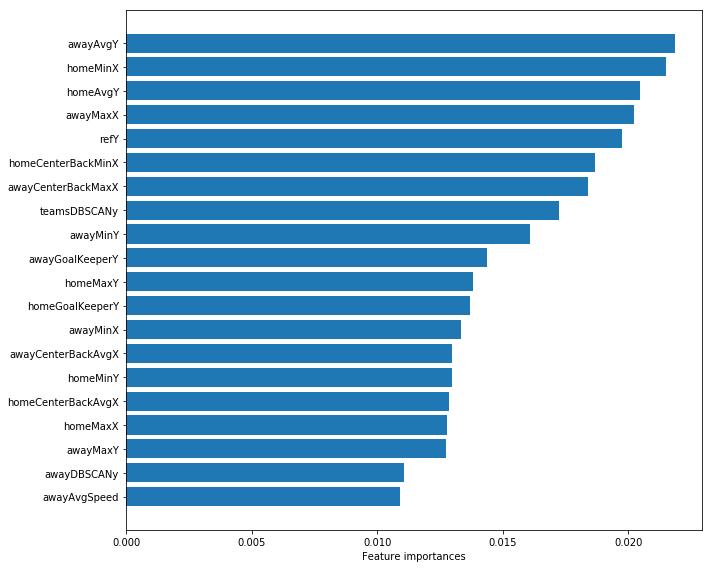

In [16]:
x_train = train_data.values[:, 0:-3]
y_train = train_data.values[:, -3]

clf = RandomForestClassifier(
    n_estimators=128,
    criterion='gini',
    min_samples_split=13,
    max_features='sqrt',
    class_weight='balanced_subsample'
)
ac, cm, fi = random_forest_cv( 
    clf,
    x_train,
    y_train,
    feature_names,
    classes=classes,
    k=10
)

Overall: 67%

## Regression Testing

### Cross Validation Function for Regression
In this section, we test our model parameters using cross validation on training data. Regression used in this section is not previously trained. Hence, it is not our final model.

In [4]:
def RF_regression_cv(clf, X, y, feature_names, k = 10):
    label_ids = sorted(np.unique(y), key=abs)
    
    # shuffle the data
    X, y = shuffle(X, y)
    
    
    # Scale the data to be between -1 and 1
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    # get K folds
    skf = KFold(n_splits = k)
    skf.get_n_splits(X, y)
    
    # cumulative mean square error array (MSE), feature importance arrays, and accurency_score variable
    feature_importances = np.zeros(X.shape[1])
    stdError = 0.0
    accuracy_score = 0.0
    
    # for each fold in KFold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # fit with current train set
        clf = clf.fit(X_train,y_train)
        
        # predict the current test set
        y_pred = clf.predict(X_test)
        
        
        # keep cumlative sum of MSE, score and features_importnaec
        accuracy_score+=clf.score(X_test, y_test)
        stdError += np.sqrt(mean_squared_error(y_test, y_pred))
        feature_importances += clf.feature_importances_
        
        
    # normalize importances
    feature_importances /= k
    # average MSE
    stdError /= k
    # average score
    accuracy_score /= k
        
    plot_hbar_nameval(feature_names, feature_importances, 'Feature importances', max_bars=20)
    
    return accuracy_score, stdError, feature_importances

### Prepare data

In [4]:
all_data = pd.read_csv('../data/general/all/data_all_3.csv')

#### *i.Remove null events*

In [7]:
all_data = all_data[all_data['pitch_index'] !=0 ]

#### *ii.Scale data* 

In [10]:
X = all_data.values[:, 0:-3]
y = all_data.values[:, -2]

# shuffle the data
X, y = shuffle(X, y)

# Scale the data to be between -1 and 1
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#### *iii.Split data* 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model Testing for X-axis

In [6]:
# model
clf = RandomForestRegressor(
    n_estimators=128,
    criterion='mse',
    min_samples_split=13,
    max_features='sqrt',
)

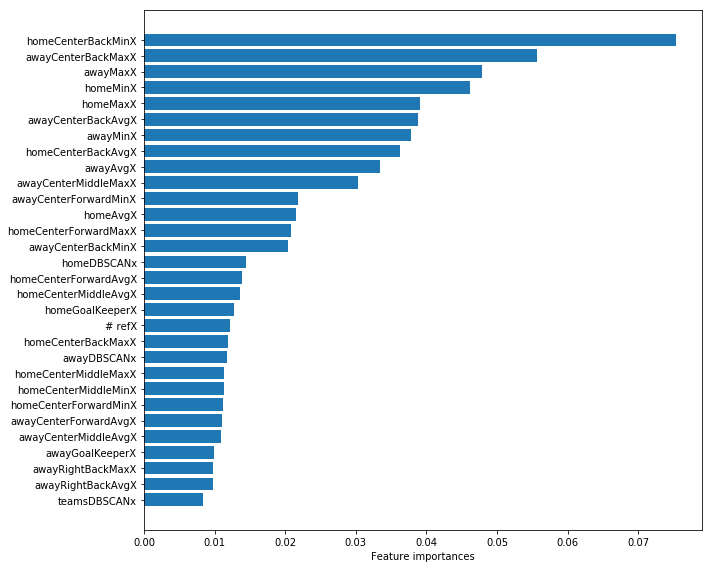

In [12]:
# fit with current train set
clf = clf.fit(X_train,y_train)

# predict the current test set
y_pred = clf.predict(X_test)


accuracy_score = clf.score(X_test, y_test)
stdError = np.sqrt(mean_squared_error(y_test, y_pred))
feature_importances = clf.feature_importances_

plot_hbar_nameval(feature_names, feature_importances, 'Feature importances', max_bars=30)

In [20]:
print('Overall accuracy: {ac}\nMean Sqr Error: {er}'.format(ac=accuracy_score, er=stdError))

Overall accuracy: 0.8074149746529351
Mean Sqr Error: 10.856083598727968


## Model Testing for Y-axis

In [15]:
all_data = pd.read_csv('../data/general/all/data_all_3.csv')

all_data = all_data[all_data['pitch_index'] !=0 ]

In [8]:
X = all_data.values[:, 0:-3]
y = all_data.values[:, -1]

# shuffle the data
X, y = shuffle(X, y)

# Scale the data to be between -1 and 1
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

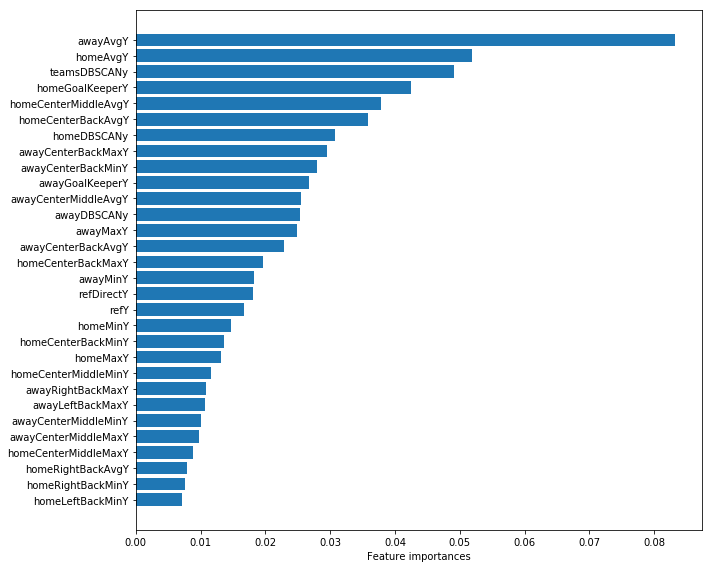

In [10]:
# fit with current train set
clf = clf.fit(X_train,y_train)

# predict the current test set
y_pred = clf.predict(X_test)


accuracy_score = clf.score(X_test, y_test)
stdError = np.sqrt(mean_squared_error(y_test, y_pred))
feature_importances = clf.feature_importances_

plot_hbar_nameval(feature_names, feature_importances, 'Feature importances', max_bars=30)

In [11]:
print('Overall accuracy: {ac}\nMean Sqr Error: {er}'.format(ac=accuracy_score, er=stdError))

Overall accuracy: 0.7579330812450005
Mean Sqr Error: 9.33407373792307
